16 numeric predictors  : # patients, country_n, site_n, assessments_n, start_date, patients_per_site, num_arms, active_prob, elig_crit_n, age_min, age_max, age_range, freq_in_window, novelty_score, complexity_score_100, attractiveness_score_100
17 categorical predictors: phase, sponsor_class, condition_top, therapeutic_area, intervention_type, assessments_complexity, global_trial, masking_level, population_class, cohort_design, study_type, allocation, masking_flag, placebo_flag, randomized_flag, fda_drug_flag, fda_device_flag



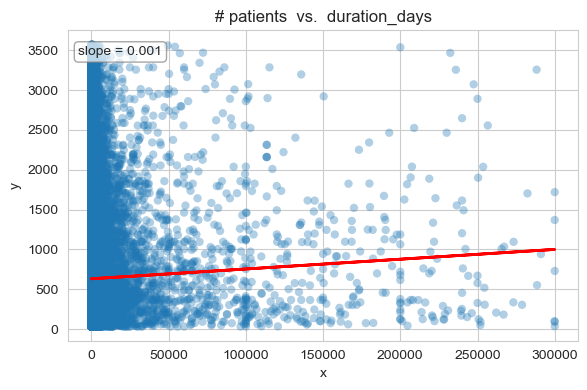

[01/16] Plotted numeric # patients


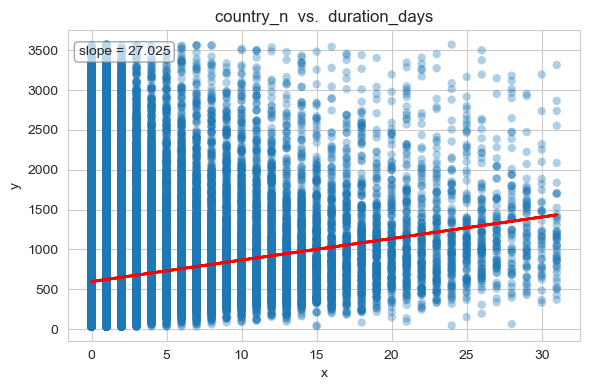

[02/16] Plotted numeric country_n


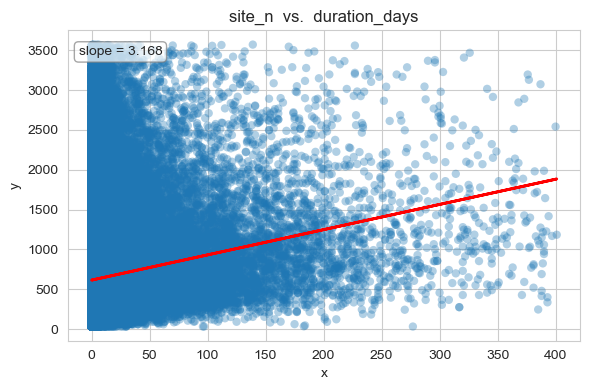

[03/16] Plotted numeric site_n


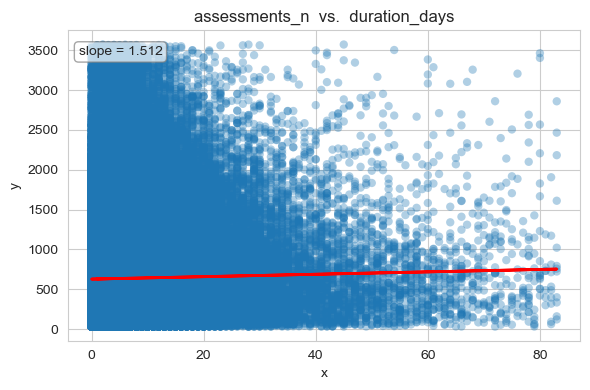

[04/16] Plotted numeric assessments_n


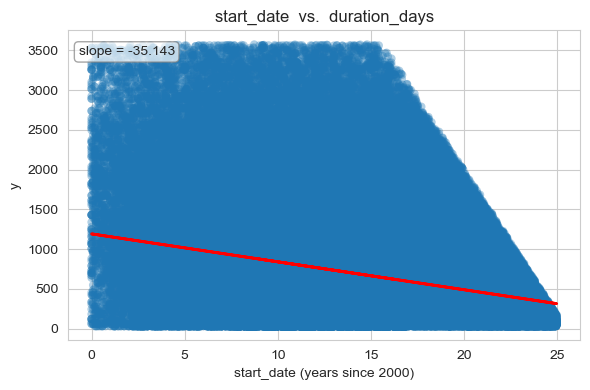

[05/16] Plotted numeric start_date


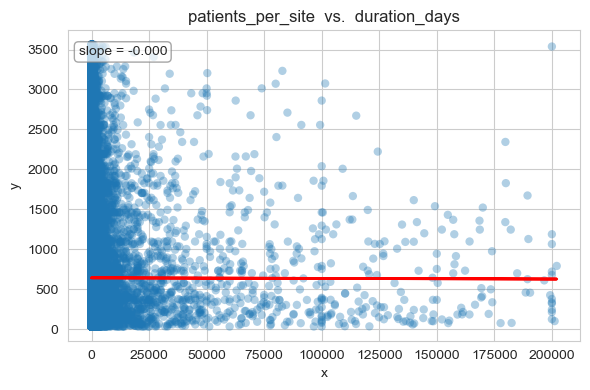

[06/16] Plotted numeric patients_per_site


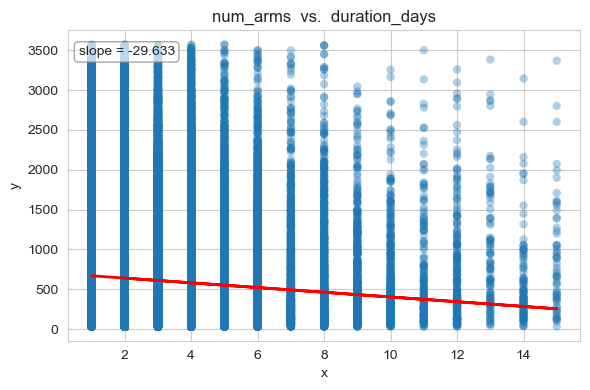

[07/16] Plotted numeric num_arms


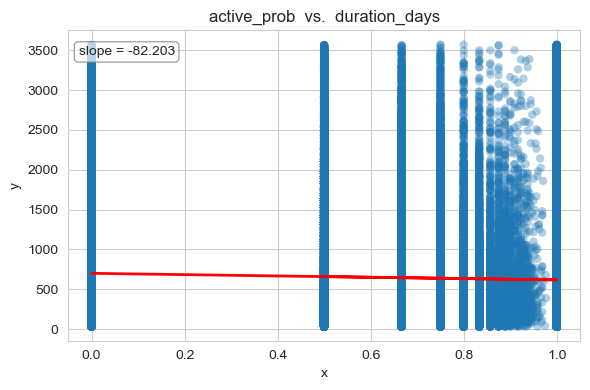

[08/16] Plotted numeric active_prob


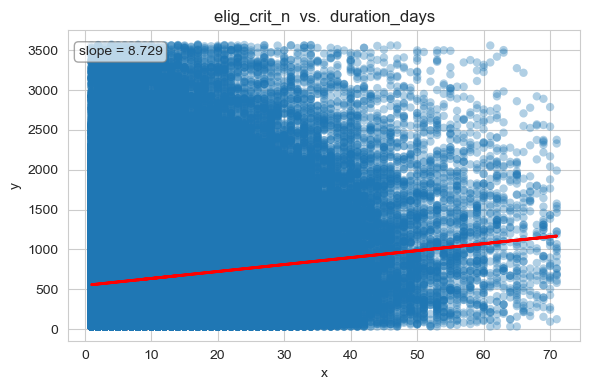

[09/16] Plotted numeric elig_crit_n


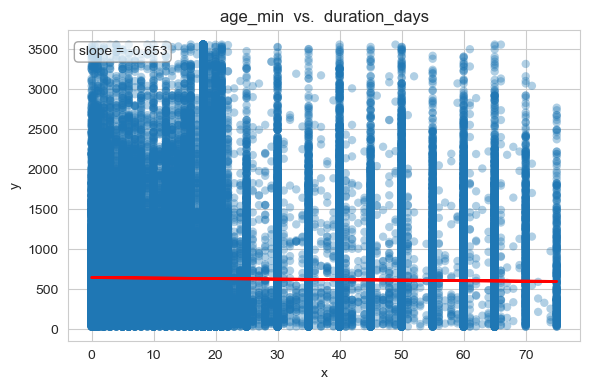

[10/16] Plotted numeric age_min


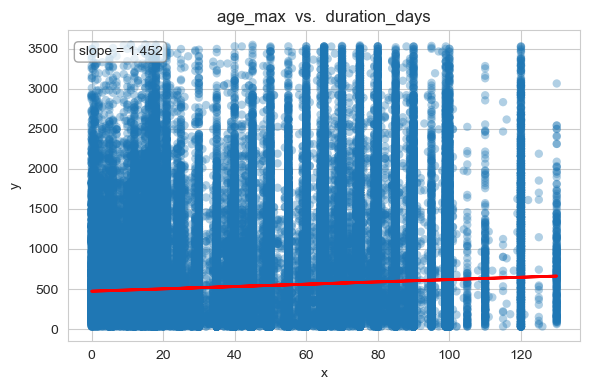

[11/16] Plotted numeric age_max


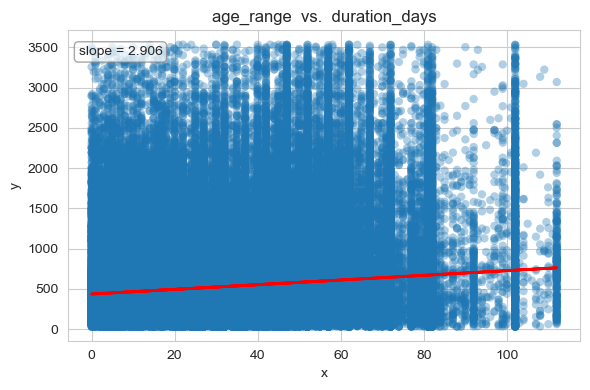

[12/16] Plotted numeric age_range


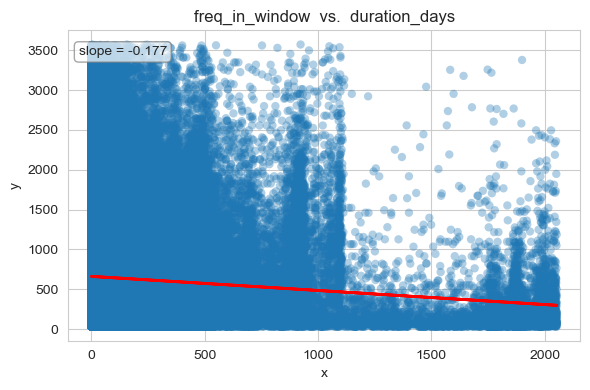

[13/16] Plotted numeric freq_in_window


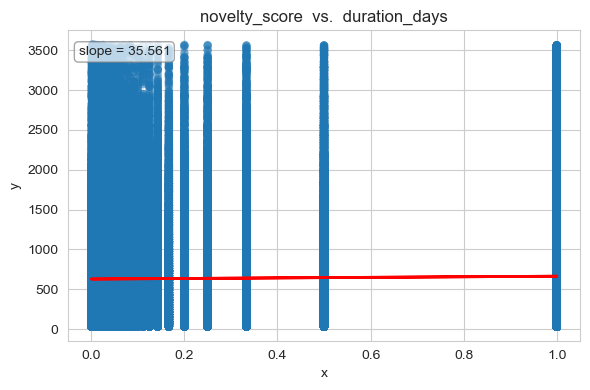

[14/16] Plotted numeric novelty_score


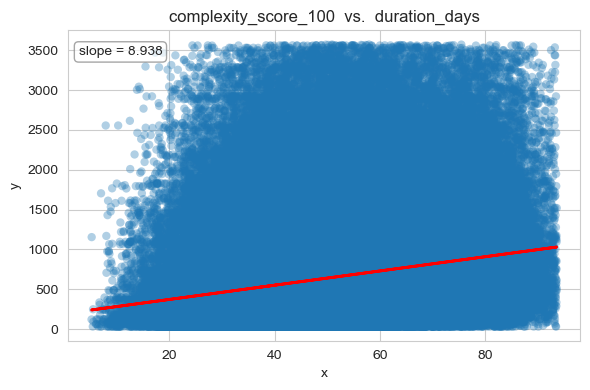

[15/16] Plotted numeric complexity_score_100


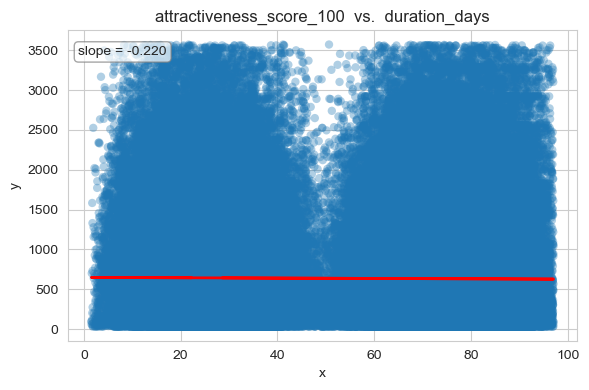

[16/16] Plotted numeric attractiveness_score_100


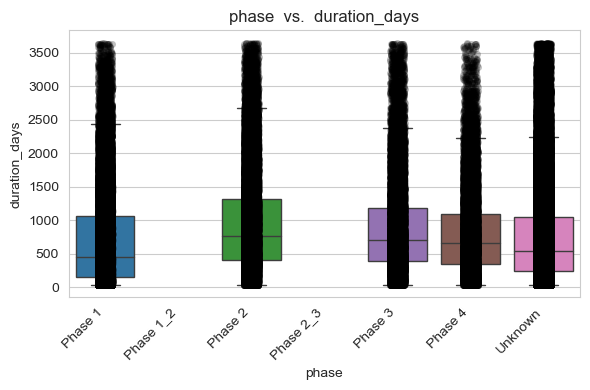

[01/17] Plotted cat phase


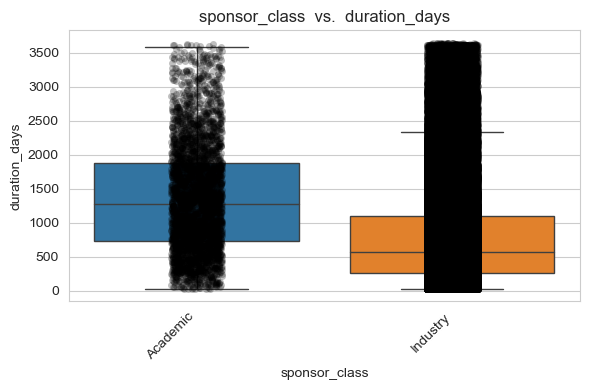

[02/17] Plotted cat sponsor_class
[03/17] Skip cat condition_top (46801 levels)


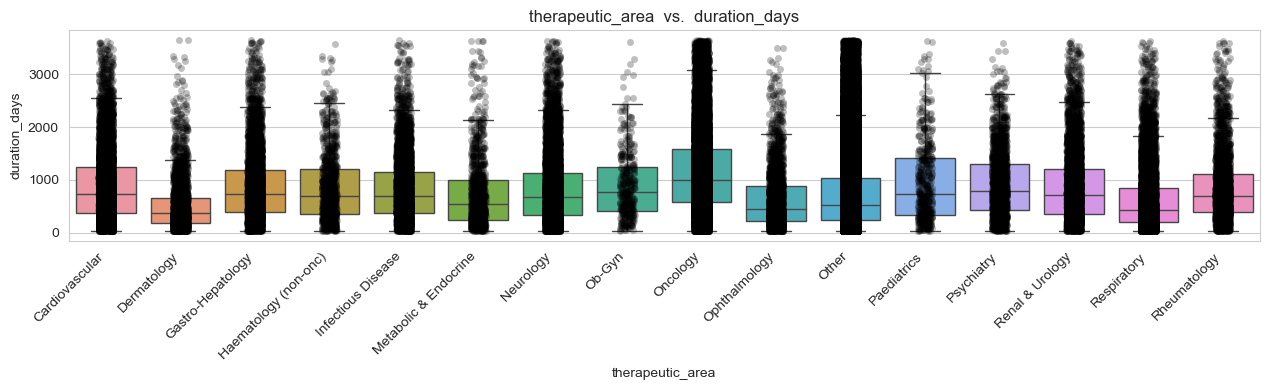

[04/17] Plotted cat therapeutic_area


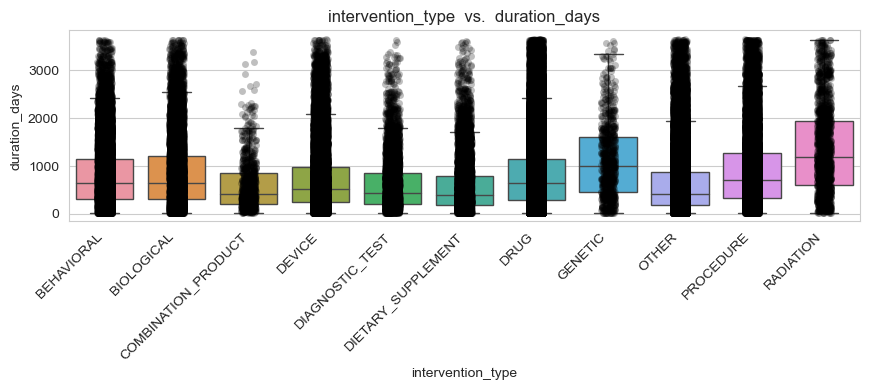

[05/17] Plotted cat intervention_type


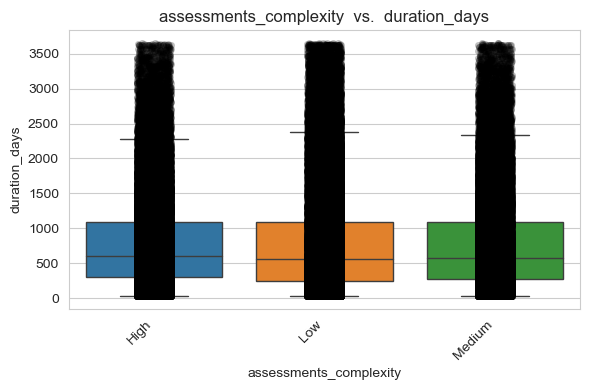

[06/17] Plotted cat assessments_complexity


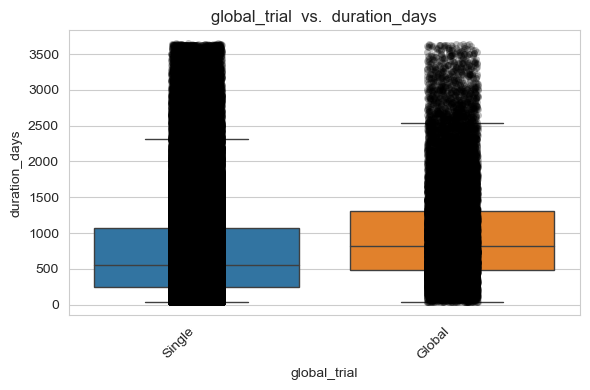

[07/17] Plotted cat global_trial


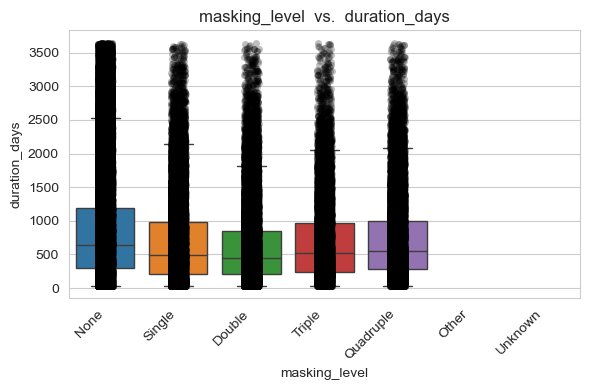

[08/17] Plotted cat masking_level


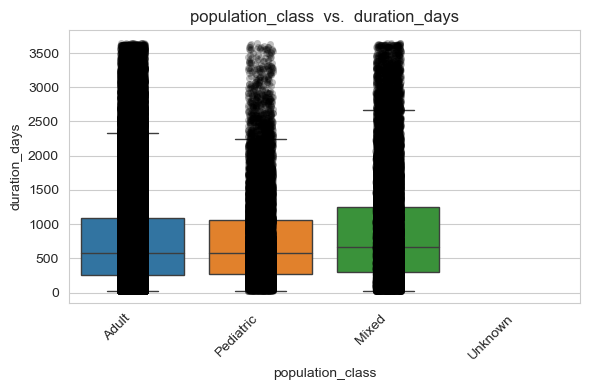

[09/17] Plotted cat population_class


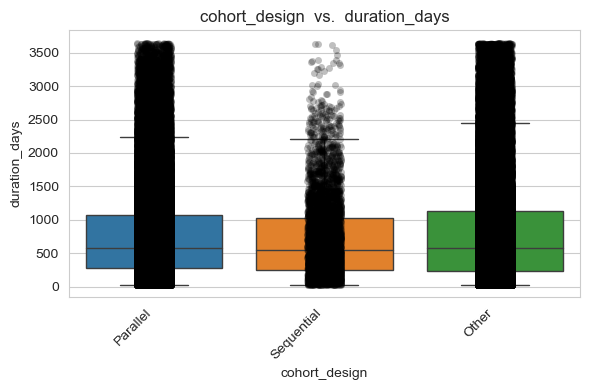

[10/17] Plotted cat cohort_design


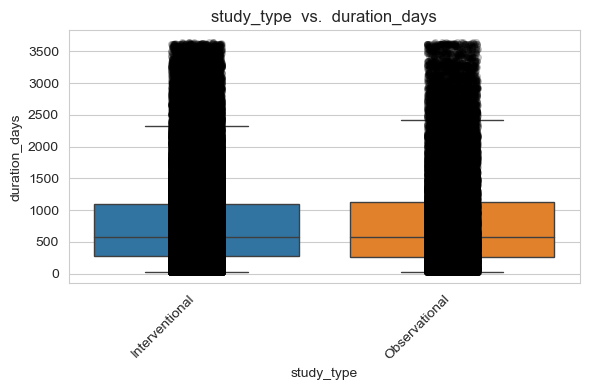

[11/17] Plotted cat study_type


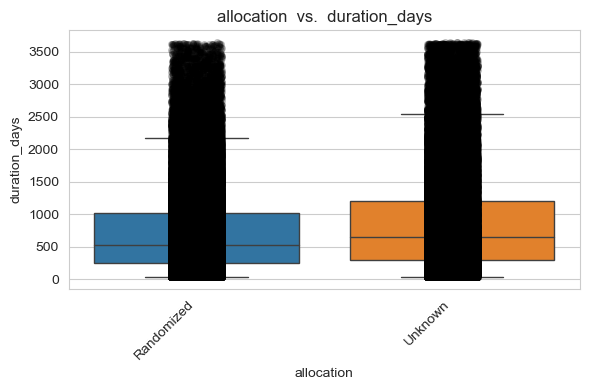

[12/17] Plotted cat allocation


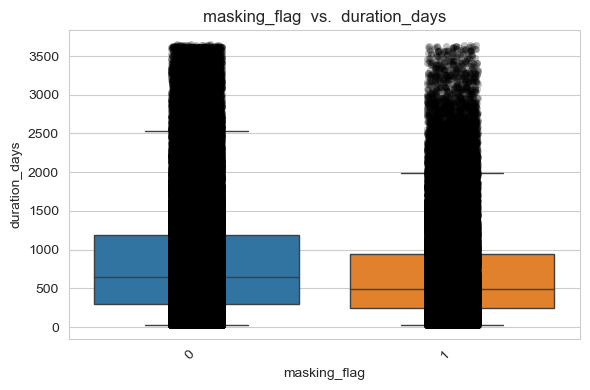

[13/17] Plotted cat masking_flag


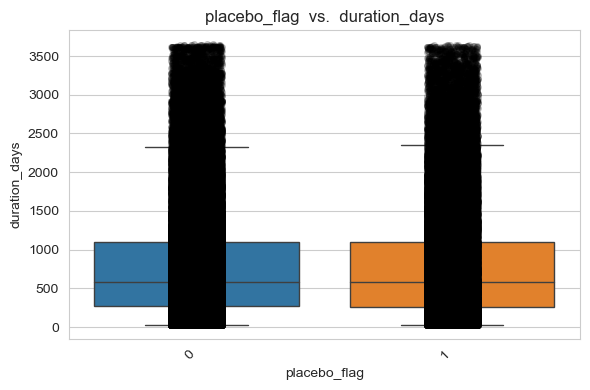

[14/17] Plotted cat placebo_flag


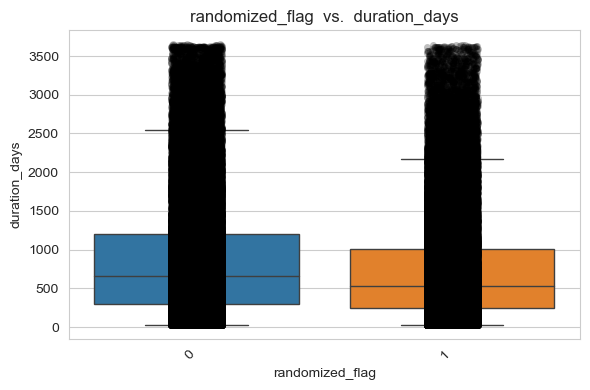

[15/17] Plotted cat randomized_flag


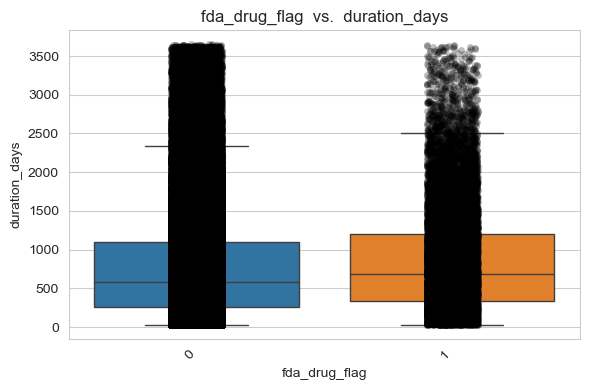

[16/17] Plotted cat fda_drug_flag


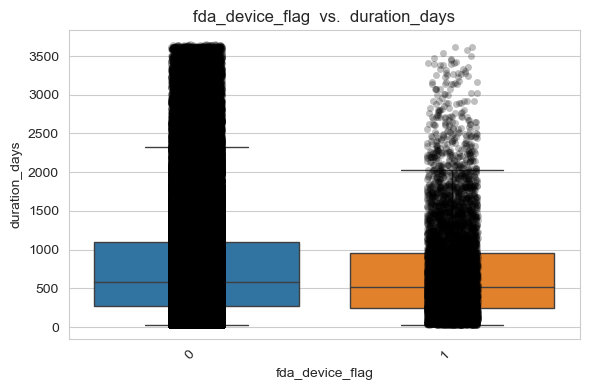

[17/17] Plotted cat fda_device_flag


In [56]:
from pathlib import Path
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import time

sns.set_style("whitegrid")

# Load
PARQUET = Path(
    "/Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/"
    "UCL MSc DSML/MSc Project/data/processed/features_v4.parquet"
)  
df = pq.read_table(PARQUET).to_pandas()

target = "duration_days"# response variable

# Feature list
manual_numeric = [
    "# patients", "country_n", "site_n",
    "assessments_n", "primary_out_n", "secondary_out_n", "other_out_n",
    "start_date", "patients_per_site", "num_arms",
    "active_prob", "elig_crit_n", "safety_cuts",
    "age_min", "age_max", "age_range",
    "freq_in_window", "novelty_score",
    "complexity_score_100", "attractiveness_score_100",
]

manual_categorical = [
    "phase", "sponsor_class", "condition_top", "therapeutic_area",
    "intervention_type", "assessments_complexity", "global_trial",
    "masking_level", "population_class", "cohort_design",
    "study_type", "allocation",
    "masking_flag", "placebo_flag",
    "randomized_flag", "fda_drug_flag", "fda_device_flag",
]

# Remove blank/duplicate names and keep only columns that actually exist
numeric_cols = [c for c in manual_numeric if c and c in df.columns]
categorical_cols = [c for c in manual_categorical if c and c in df.columns]

# Cast categoricals to pandas 'category'
df[categorical_cols] = df[categorical_cols].apply(lambda s: s.astype("category"))

print(f"{len(numeric_cols)} numeric predictors  : " + ", ".join(numeric_cols))
print(f"{len(categorical_cols)} categorical predictors: " + ", ".join(categorical_cols))
print()

# Numeric features: scatter + trendline 
from sklearn.linear_model import HuberRegressor

for i, col in enumerate(numeric_cols, 1):
    if col == target:
        continue

    subset = df[[col, target]].dropna()
    if len(subset) < 2 or subset[col].nunique() < 2:
        print(f"[{i:02}/{len(numeric_cols)}] Skip numeric {col} (insufficient data)")
        continue

    # Handle datetime columns only for start_date and complete_date
    x = subset[col]
    if np.issubdtype(x.dtype, np.datetime64) and col in ["start_date"]:
        x = (x - pd.Timestamp("2000-01-01")).dt.total_seconds() / (365.25 * 24 * 3600)
    elif np.issubdtype(x.dtype, np.datetime64):
        x = x.view("int64") / 24 / 3600 / 1e9  # Default conversion for other datetime columns

    y = subset[target]
    
    # Drop rows outside the 0.0001–0.999 quantile range (no clipping)
    lo_x, hi_x = x.quantile([0.0001, 0.999])
    lo_y, hi_y = y.quantile([0.0001, 0.999])
    mask = (x.between(lo_x, hi_x)) & (y.between(lo_y, hi_y))
    subset_trimmed = pd.DataFrame({'x': x[mask], 'y': y[mask]})
   
    if len(subset_trimmed) < 2 or subset_trimmed['x'].nunique() < 2:
        print(f"[{i:02}/{len(numeric_cols)}] Skip numeric {col} (insufficient data after trimming)")
        continue

    # Regression model: HuberRegressor 
    model = HuberRegressor(epsilon=1.35)
    model.fit(subset_trimmed[['x']], subset_trimmed['y'])
    y_pred = model.predict(subset_trimmed[['x']])
    slope = model.coef_[0]  # Extract the slope from the model

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=subset_trimmed['x'], y=subset_trimmed['y'], alpha=0.35, edgecolor="none")
    plt.plot(subset_trimmed['x'], y_pred, color='red', linewidth=2)
    plt.text(
        0.02, 0.95, f"slope = {slope:.3f}",
        transform=plt.gca().transAxes, ha="left", va="top",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
    )
    plt.title(f"{col}  vs.  {target}")
    if col in ["start_date", "complete_date"]:
        plt.xlabel(f"{col} (years since 2000)")
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"[{i:02}/{len(numeric_cols)}] Plotted numeric {col}")
    time.sleep(0.05)

# Categorical features -> box + strip
for i, col in enumerate(categorical_cols, 1):
    subset = df[[col, target]].dropna()
    n_levels = subset[col].nunique(dropna=True)

    if len(subset) == 0 or n_levels == 0:
        print(f"[{i:02}/{len(categorical_cols)}] Skip cat {col} (no data)")
        continue
    if n_levels > 50:
        print(f"[{i:02}/{len(categorical_cols)}] Skip cat {col} ({n_levels} levels)")
        continue

    plt.figure(figsize=(max(6, n_levels * 0.8), 4))
    sns.boxplot(data=subset, x=col, y=target, showfliers=False, linewidth=1)
    sns.stripplot(data=subset, x=col, y=target, alpha=0.25,
                  color="black", jitter=True)
    plt.title(f"{col}  vs.  {target}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"[{i:02}/{len(categorical_cols)}] Plotted cat {col}")
    time.sleep(0.05)